In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
from scipy import ndimage
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

In [2]:
folder_path = "images"
save_folder = 'segmentation_masks'
os.makedirs(save_folder, exist_ok=True)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
#dinov2_vitl14
#dinov2_vitg14
model = model.to(device)
model.eval()

Using cache found in /Users/kash/.cache/torch/hub/facebookresearch_dinov2_main
/Users/kash/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/kash/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/kash/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [5]:
preprocess = transforms.Compose([
    transforms.Resize((518, 518)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:


def get_segmentation(image_path, num_segments=12):
    image_orig = Image.open(image_path).convert("RGB")
    image_np = np.array(image_orig)
    image_np = cv2.medianBlur(image_np, 5) 
    image = Image.fromarray(image_np)

    input_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.forward_features(input_tensor)

    # Use patch tokens
    patch_tokens = features['x_norm_patchtokens'].squeeze(0).cpu()
    feature_map = patch_tokens.reshape(37, 37, -1)  # Include CLS token

    reshaped_features = feature_map.reshape(-1, feature_map.shape[2])

    # Apply PCA
    pca = PCA(n_components=0.99)  # Retain 95% of variance
    reduced_features = pca.fit_transform(reshaped_features)

    # Use Gaussian Mixture Model for clustering
    kmeans = KMeans(n_clusters=num_segments, random_state=0)
    segmentation_map = kmeans.fit_predict(reduced_features).reshape(37, 37)    
    segmentation_map = cv2.resize(segmentation_map, (512,512), interpolation=cv2.INTER_NEAREST)
    segmentation_map_smooth = ndimage.median_filter(segmentation_map, size=15)

    return image_orig,image, segmentation_map, segmentation_map_smooth

/Users/kash/miniconda/envs/test/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


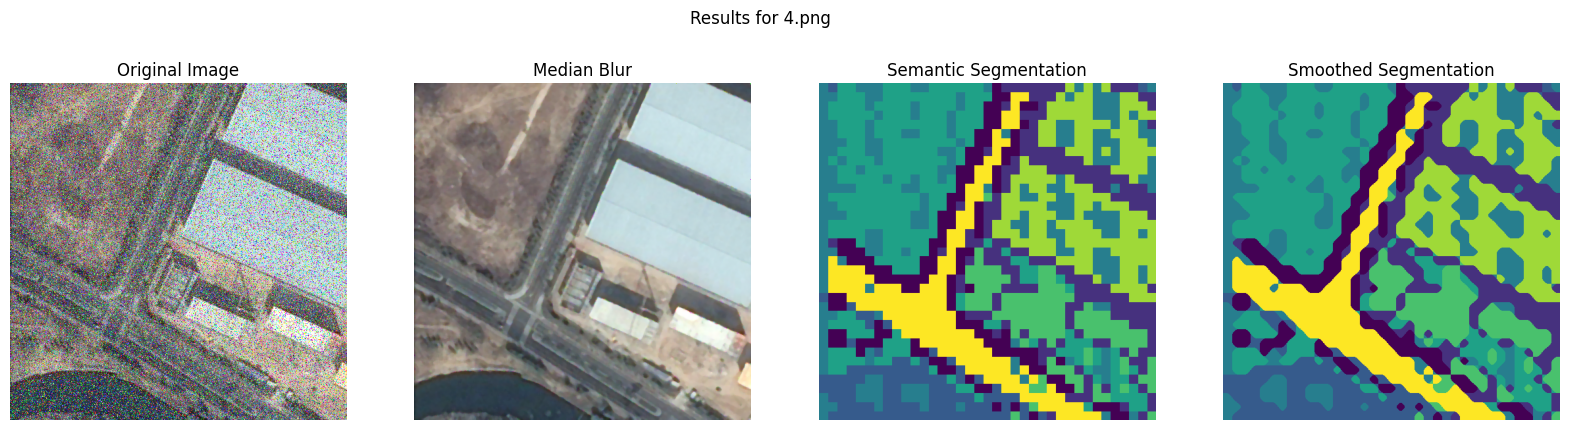

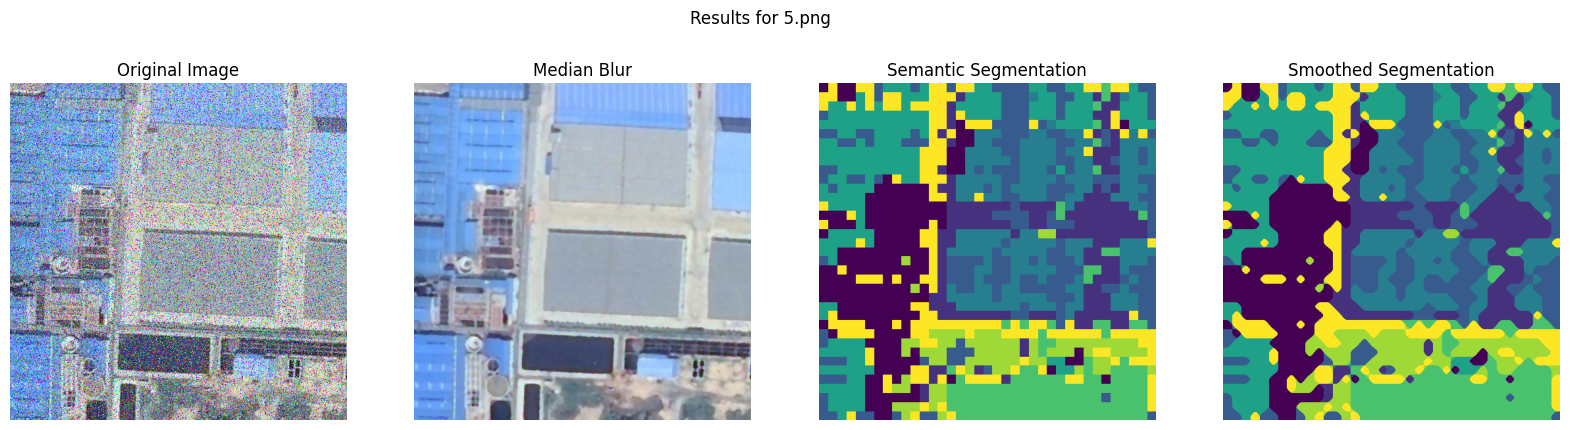

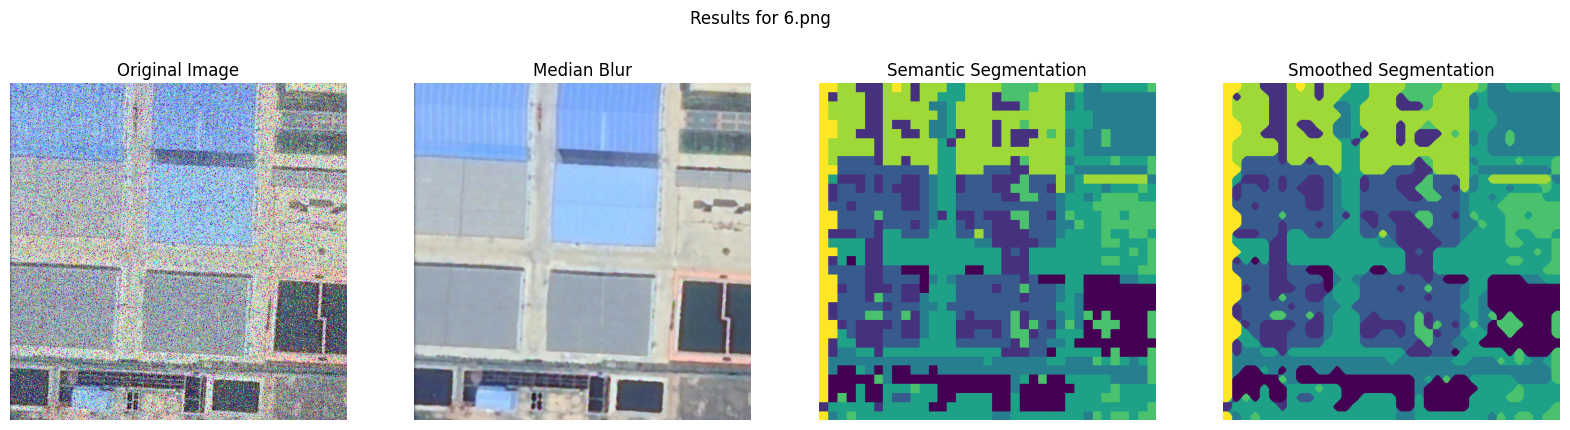

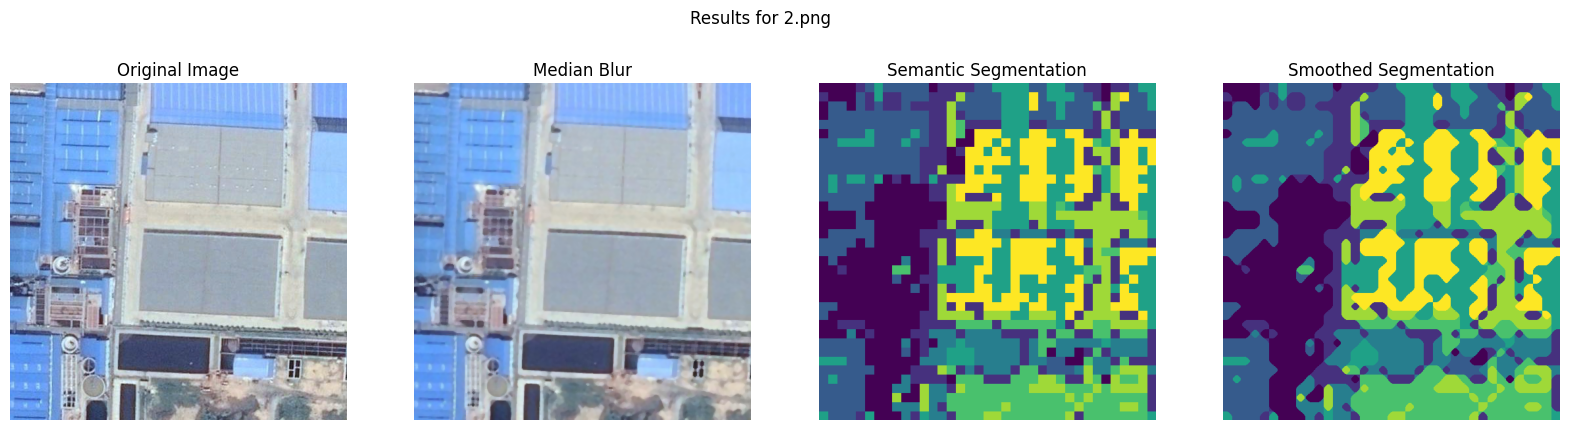

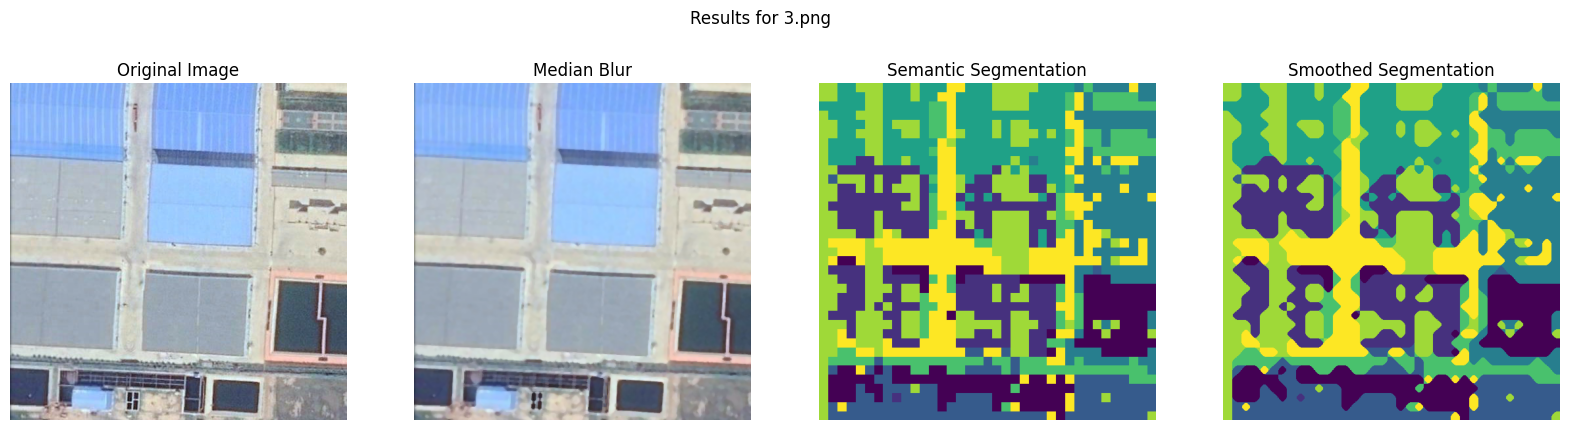

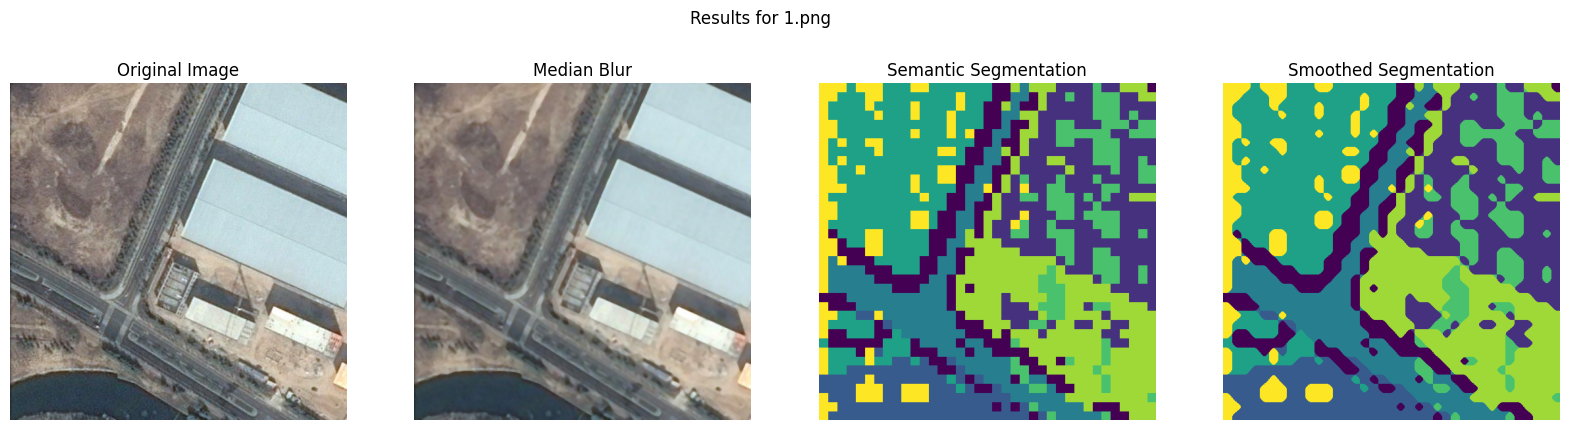

Segmentation maps saved in the 'segmentation masks' folder.


In [7]:
for filename in os.listdir(folder_path):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(folder_path, filename)
        image_orig, image, segmentation_map, segmentation_map_smooth = get_segmentation(image_path, 8)

        plt.imsave(os.path.join(save_folder, f"{filename.split('.')[0]}_segmentation_map.png"), segmentation_map, cmap='viridis')
        plt.imsave(os.path.join(save_folder, f"{filename.split('.')[0]}_segmentation_map_smooth.png"), segmentation_map_smooth, cmap='viridis')

        plt.figure(figsize=(20, 5))
        plt.suptitle(f"Results for {filename}")

        plt.subplot(1, 4, 1)
        plt.imshow(image_orig)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(image)
        plt.title("Median Blur")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(segmentation_map, cmap='viridis')
        plt.title("Semantic Segmentation")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(segmentation_map_smooth, cmap='viridis')
        plt.title("Smoothed Segmentation")
        plt.axis('off')

        plt.show()

print("Segmentation maps saved in the 'segmentation masks' folder.")